In [50]:
# Core data analysis packages
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# import our files
user_artists = pd.read_csv('data/user_artists.dat',sep='\t')
artists = pd.read_csv('data/artists.dat',sep='\t',usecols=['id','name'])
tags = pd.read_csv('data/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('data/user_taggedartists.dat', sep='\t')
utat = pd.read_csv('data/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('data/user_friends.dat', sep='\t')

## Step 2: Exploratory Data Analysis (EDA) and Preprocessing

In [3]:
num_users = user_artists['userID'].nunique()
num_artists = user_artists['artistID'].nunique()
print(f"Total users: {num_users}, Total artists: {num_artists}")

Total users: 1892, Total artists: 17632


In [4]:
#Create a binary version: 1 if a user has played the artist at least 1000 time. We will use this later to decide the commun neighbors.
user_artists['played'] = (user_artists['weight'] > 500).astype(int)

In [5]:
user_artists.weight.describe() # 75% of the users have played the artist less than 187 times. The max is 352698

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

## Step 3: Building the Graph Representation

In [6]:
B = nx.Graph()

users = user_artists['userID'].unique()
B.add_nodes_from(users, bipartite='users')

artist_ids = user_artists['artistID'].unique()
artist_nodes = [f"artist_{artist}" for artist in artist_ids]
B.add_nodes_from(artist_nodes, bipartite='artists')

edges = []
for row in user_artists.itertuples(index=False):
    if row.played == 1:
        user_id = row.userID
        artist_id = row.artistID
        # Append the edge only when played == 1
        edges.append((user_id, f"artist_{artist_id}", row.played))

B.add_weighted_edges_from(edges)

print("Total nodes in bipartite graph:", B.number_of_nodes())
print("Total edges in bipartite graph:", B.number_of_edges())


Total nodes in bipartite graph: 19524
Total edges in bipartite graph: 28127


## Step 3: Build the user-user graph

In [7]:
from networkx.algorithms import bipartite

# Project the bipartite graph onto the user nodes.
user_graph = bipartite.weighted_projected_graph(B, users)

print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Unique users:", len(users)) # just to ensure what we are doing is correct

Total nodes in user graph: 1892
Unique users: 1892


In [8]:
print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Total edges in user graph:", user_graph.number_of_edges())

Total nodes in user graph: 1892
Total edges in user graph: 298302


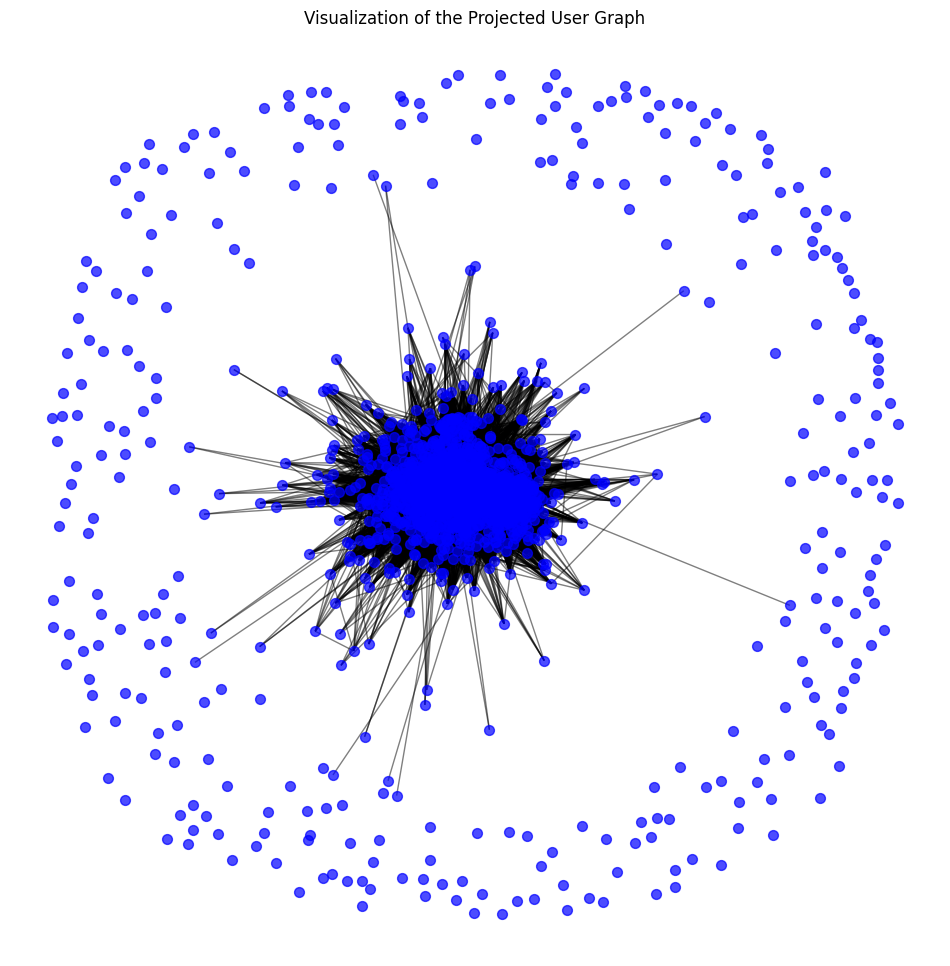

In [9]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_graph, k=0.1, iterations=20)
nx.draw_networkx_nodes(user_graph, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(user_graph, pos, alpha=0.5)
plt.title("Visualization of the Projected User Graph")
plt.axis('off')
plt.show()

## Step 4: Graph-based similarity methods:

### Jaccard Coefficient

In [10]:
# Create candidate pairs (for all pairs where u < v)
candidate_pairs = [(u, v) for u in user_graph.nodes() for v in user_graph.nodes() if u < v]

# 1. Jaccard Coefficient
jaccard_gen = nx.jaccard_coefficient(user_graph, candidate_pairs)
jaccard_df = pd.DataFrame(jaccard_gen, columns=['user1', 'user2', 'jaccard'])

### Adamic–Adar Index

In [11]:
# 2. Adamic–Adar Index
adamic_gen = nx.adamic_adar_index(user_graph, candidate_pairs)
adamic_df = pd.DataFrame(adamic_gen, columns=['user1', 'user2', 'adamic_adar'])

### Common Neighbors

In [12]:
# 3. Common Neighbors for a specific pair:
def common_neighbors_score(u, v, G):
    """Return the number of common neighbors between u and v."""
    return len(list(nx.common_neighbors(G, u, v)))

In [13]:
# Create a DataFrame to store the scores
pairs_df = pd.DataFrame(candidate_pairs, columns=['user1', 'user2'])

pairs_df['common_neighbors'] = pairs_df.apply(lambda row: common_neighbors_score(row['user1'], row['user2'], user_graph), axis=1)

In [14]:
pairs_df = pairs_df.merge(jaccard_df, on=['user1', 'user2'])
pairs_df = pairs_df.merge(adamic_df, on=['user1', 'user2'])

pairs_df.head()

,user1,user2,common_neighbors,jaccard,adamic_adar
0,2,3,1,0.001361,0.159902
1,2,4,325,0.367232,53.339691
2,2,5,163,0.186712,25.587141
3,2,6,0,0.000000,0.000000
4,2,7,485,0.541295,76.426815


In [15]:
def get_edge_weight(row):
    u, v = row['user1'], row['user2']
    # Check if there is an edge between u and v in the projected graph:
    if user_graph.has_edge(u, v):
        return user_graph[u][v].get('weight')
    else:
        return 0

# Apply the function row-wise to create a new column 'edge_weight'
pairs_df['edge_weight'] = pairs_df.apply(get_edge_weight, axis=1)

## Step 5: Thresholding the scores to decide music friends

In [16]:
scores = pairs_df['common_neighbors'].values

scores_adamic = pd.Series(scores)
scores_adamic.quantile(0.9) # we will consider the 90% percentile as a threshold to decide if two users are music friends or not

np.float64(291.0)

In [17]:
threshold_aa = 46
threshold_jc = 0.38
threshold_cn = 291

pairs_df['mf_aa'] = pairs_df['adamic_adar'] > threshold_aa
pairs_df['mf_jc'] = pairs_df['jaccard'] > threshold_jc
pairs_df['mf_cn'] = pairs_df['common_neighbors'] > threshold_cn

In [18]:
pairs_df.head()

,user1,user2,common_neighbors,jaccard,adamic_adar,edge_weight,mf_aa,mf_jc,mf_cn
0,2,3,1,0.001361,0.159902,0,False,False,False
1,2,4,325,0.367232,53.339691,2,True,False,True
2,2,5,163,0.186712,25.587141,0,False,False,False
3,2,6,0,0.000000,0.000000,0,False,False,False
4,2,7,485,0.541295,76.426815,3,True,True,True


## Step 5: Evaluation metrics

We will evaluate the precision of our detection of music friends based similarity metrics with the real friends in real life to see how likely we can detect true friends only based on their music similarities

In [19]:
friendship_pairs = set((row.userID, row.friendID) for row in friends.itertuples(index=False))

In [20]:
pairs_df['is_friend'] = pairs_df.apply(lambda row: (row['user1'], row['user2']) in friendship_pairs or (row['user2'], row['user1']) in friendship_pairs, axis=1)

In [21]:
pairs_df.head()

,user1,user2,common_neighbors,jaccard,adamic_adar,edge_weight,mf_aa,mf_jc,mf_cn,is_friend
0,2,3,1,0.001361,0.159902,0,False,False,False,False
1,2,4,325,0.367232,53.339691,2,True,False,True,False
2,2,5,163,0.186712,25.587141,0,False,False,False,False
3,2,6,0,0.000000,0.000000,0,False,False,False,False
4,2,7,485,0.541295,76.426815,3,True,True,True,False


## Step 6: Apply GNN to detect mf_jc:

In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into 80% training and 20% testing.
# The 'stratify' parameter ensures the proportion of friend (True) and non-friend (False) pairs is maintained.
train_df, test_df = train_test_split(
    pairs_df,
    test_size=0.2,
    random_state=42,
    stratify=pairs_df['mf_jc']
)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1431108, 10)
Test set shape: (357778, 10)


### 1. Prepare the Graph Data

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.optim as optim
import torch.nn as nn

mapping = {node: i for i, node in enumerate(user_graph.nodes())}
num_users = len(mapping)

# Create edge_index using the mapped indices.
edge_list = []
for u, v in user_graph.edges():
    # Map both endpoints to their new indices.
    edge_list.append((mapping[u], mapping[v]))
    edge_list.append((mapping[v], mapping[u]))  # because the graph is undirected

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

x = torch.eye(num_users, dtype=torch.float)

# Create the PyG Data object.
data = Data(x=x, edge_index=edge_index)

### 2. Prepare Candidate Pair Tensors from DataFrames

In [44]:
def df_to_edge_tensor(df, mapping):
    # For each row in the DataFrame, convert original user IDs to indices.
    edges = []
    for _, row in df.iterrows():
        try:
            u_idx = mapping[row['user1']]
            v_idx = mapping[row['user2']]
            edges.append([u_idx, v_idx])
        except KeyError as e:
            print(f"Warning: {e} not found in mapping. Skipping pair ({row['user1']}, {row['user2']}).")
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

# Convert the training and testing DataFrames to candidate edge tensors.
train_pairs = df_to_edge_tensor(train_df, mapping)
train_labels = torch.tensor(train_df['mf_jc'].values, dtype=torch.float)

test_pairs = df_to_edge_tensor(test_df, mapping)
test_labels = torch.tensor(test_df['mf_jc'].values, dtype=torch.float)

### 3. Define the GNN Model for Link Prediction

In [45]:
class GNNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNLinkPredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.decoder = nn.Sequential(
            nn.Linear(2 * out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, candidate_edges):
        src, dst = candidate_edges  # each of shape [num_edges]
        pair_emb = torch.cat([z[src], z[dst]], dim=1)
        return torch.sigmoid(self.decoder(pair_emb)).view(-1)

    def forward(self, data, candidate_edges):
        z = self.encode(data.x, data.edge_index)
        return self.decode(z, candidate_edges)

# Note: Since our node features are one-hot vectors of dimension num_users, we use that as in_channels.
model = GNNLinkPredictor(in_channels=num_users, hidden_channels=16, out_channels=16)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

### 4. Training and Testing Functions

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(data, train_pairs)
    loss = criterion(pred, train_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        pred = model(data, test_pairs)
        pred_binary = (pred > 0.5).float()
        correct = (pred_binary == test_labels).sum().item()
        acc = correct / test_labels.size(0)
    return acc


for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

Epoch 0, Loss: 0.2855, Test Accuracy: 0.8968
Epoch 10, Loss: 0.2763, Test Accuracy: 0.8968
Epoch 20, Loss: 0.2690, Test Accuracy: 0.8968
Epoch 30, Loss: 0.2646, Test Accuracy: 0.8968
Epoch 40, Loss: 0.2613, Test Accuracy: 0.8968
Epoch 50, Loss: 0.2592, Test Accuracy: 0.8968
Epoch 60, Loss: 0.2577, Test Accuracy: 0.8968
Epoch 70, Loss: 0.2566, Test Accuracy: 0.8968
Epoch 80, Loss: 0.2556, Test Accuracy: 0.8968
Epoch 90, Loss: 0.2547, Test Accuracy: 0.8968
Epoch 100, Loss: 0.2528, Test Accuracy: 0.8968
Epoch 110, Loss: 0.2498, Test Accuracy: 0.8968
Epoch 120, Loss: 0.2460, Test Accuracy: 0.8968
Epoch 130, Loss: 0.2418, Test Accuracy: 0.9107
Epoch 140, Loss: 0.2377, Test Accuracy: 0.9139
Epoch 150, Loss: 0.2340, Test Accuracy: 0.9143
Epoch 160, Loss: 0.2311, Test Accuracy: 0.9146
Epoch 170, Loss: 0.2287, Test Accuracy: 0.9153
Epoch 180, Loss: 0.2265, Test Accuracy: 0.9162
Epoch 190, Loss: 0.2236, Test Accuracy: 0.9165


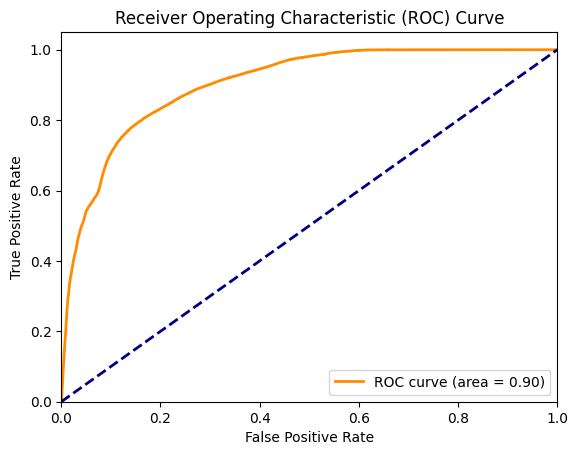

In [48]:
model.eval()
with torch.no_grad():
    pred = model(data, test_pairs)
    auc = roc_auc_score(test_labels.cpu(), pred.cpu())

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(test_labels.cpu(), pred.cpu())

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()